# 🧠 Sentiment Analysis on Amazon Reviews (PySpark + PyTorch)

Mục tiêu: 
- Làm sạch dữ liệu đánh giá sản phẩm bằng PySpark.
- Chuyển đổi dữ liệu đã xử lý sang tensor để huấn luyện mô hình PyTorch.

Công cụ:
- PySpark (xử lý dữ liệu lớn)
- PyTorch (huấn luyện mô hình Deep Learning)


## Khám phá dữ liệu (Exploratory Data Analysis - EDA)

Trong phần này, chúng ta sẽ:
- Đọc dữ liệu gốc từ file `.csv`
- Kiểm tra schema, số lượng dòng/cột
- Kiểm tra dữ liệu thiếu (null/missing)
- Chuẩn hoá cột `Rating`
- Phân tích phân bố điểm đánh giá và cảm xúc
- Tính toán độ dài review
- Phân tích theo thời gian (nếu có cột ngày đánh giá)


### Import thư viện

In [34]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

### Tạo Spark Session

In [35]:
# ==============================================================
# 🔹 Tạo SparkSession
# ==============================================================

spark = (
    SparkSession.builder
    .appName("Amazon_Review_Sentiment")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "4g")
    .config("spark.executor.cores", "4")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

### Đọc dữ liệu gốc

In [36]:
# ==============================================================
# 🔹 Đọc dữ liệu gốc
# ==============================================================

data_path = "../data/raw/Amazon_Reviews.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)

print("Đọc dữ liệu thành công.")
df.show(5, truncate=False)


Đọc dữ liệu thành công.
+----------------+-------------------------------+-------+------------+------------------------+----------------------+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|Reviewer Name   |Profile Link                   |Country|Review Count|Review Date             |Rating                |Review Title                                   |Review Tex

### Thông tin tổng quan về dữ liệu

In [37]:
# ==============================================================
# 🔹 Thông tin tổng quan
# ==============================================================

print("Schema:")
df.printSchema()

print(f"Tổng số dòng: {df.count():,}")
print(f"Tổng số cột: {len(df.columns)}")
print("Danh sách cột:", df.columns)


Schema:
root
 |-- Reviewer Name: string (nullable = true)
 |-- Profile Link: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Review Count: string (nullable = true)
 |-- Review Date: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Review Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Date of Experience: string (nullable = true)

Tổng số dòng: 21,656
Tổng số cột: 9
Danh sách cột: ['Reviewer Name', 'Profile Link', 'Country', 'Review Count', 'Review Date', 'Rating', 'Review Title', 'Review Text', 'Date of Experience']


### Kiểm tra giá trị thiếu

In [38]:
# ==============================================================
# 🔹 Kiểm tra giá trị thiếu
# ==============================================================

null_df = df.select([
    F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c)).alias(c)
    for c in df.columns
])
print("Số lượng giá trị null hoặc rỗng trong từng cột:")
null_df.show(vertical=True)

Số lượng giá trị null hoặc rỗng trong từng cột:
-RECORD 0-----------------
 Reviewer Name      | 0   
 Profile Link       | 141 
 Country            | 436 
 Review Count       | 523 
 Review Date        | 565 
 Rating             | 581 
 Review Title       | 590 
 Review Text        | 595 
 Date of Experience | 920 



### Thống kê cột Rating

In [39]:
# ==============================================================
# 🔹 Thống kê cột Rating
# ==============================================================

df = df.withColumn(
    "Rating",
    F.regexp_extract(F.col("Rating"), r"(\d)(?=\s*out of 5)", 1).cast(IntegerType())
)

# Thống kê điểm đánh giá
rating_stats = df.groupBy("Rating").agg(
    F.count("*").alias("count")
).orderBy("Rating")

print("\n Thống kê điểm Rating:")
rating_stats.show()


 Thống kê điểm Rating:
+------+-----+
|Rating|count|
+------+-----+
|  NULL|  601|
|     1|13123|
|     2| 1227|
|     3|  885|
|     4| 1292|
|     5| 4528|
+------+-----+



### Thống kê độ dài review

In [40]:
# ==============================================================
# 🔹 Thống kê độ dài nội dung Review
# ==============================================================

if "Review Text" in df.columns:
    df = df.withColumn("ReviewLength", F.length(F.col("Review Text")))

    review_stats = df.select(
        F.mean("ReviewLength").alias("mean_len"),
        F.min("ReviewLength").alias("min_len"),
        F.max("ReviewLength").alias("max_len")
    ).collect()[0]

    print(f"Độ dài trung bình: {review_stats['mean_len']:.2f}")
    print(f"Ngắn nhất: {review_stats['min_len']}, Dài nhất: {review_stats['max_len']}")


Độ dài trung bình: 422.60
Ngắn nhất: 6, Dài nhất: 8166


### Phân tích theo thời gian

In [41]:
# ==============================================================
# 🔹 Phân tích theo thời gian (nếu có cột Review Date)
# ==============================================================

if "Review Date" in df.columns:
    df = df.withColumn("Review Date", F.to_date(F.col("Review Date")))
    time_dist = df.groupBy(F.year("Review Date").alias("year")).count().orderBy("year")
    print("Số lượng review theo năm:")
    time_dist.show()

Số lượng review theo năm:
+----+-----+
|year|count|
+----+-----+
|NULL|  601|
|2007|    1|
|2008|    3|
|2009|    9|
|2010|   22|
|2011|  360|
|2012| 1166|
|2013|   88|
|2014|  166|
|2015|  175|
|2016|  317|
|2017|  616|
|2018| 1041|
|2019| 2314|
|2020| 2638|
|2021| 2750|
|2022| 2551|
|2023| 4017|
|2024| 2821|
+----+-----+



## Tiền xử lý dữ liệu (Data Preprocessing)

Trong phần này, chúng ta sẽ:
- Chuẩn hoá cột **Rating** về giá trị số (1–5)
- Gán nhãn **Sentiment** (`positive`, `negative`)
- Làm sạch văn bản: xoá ký tự đặc biệt, chữ thường, loại bỏ stopwords
- Kết hợp tiêu đề + nội dung review
- Lưu dữ liệu đã chuẩn hoá ra file `.parquet` để phục vụ huấn luyện mô hình.


### Chuẩn hoá cột Rating

In [42]:
# ==============================================================
# 🔹 Chuẩn hoá cột Rating
# ==============================================================
df = df.withColumn(
    "Rating",
    F.regexp_extract(F.col("Rating"), r"(\d+)", 1).cast(IntegerType())
)

df = df.filter((F.col("Rating") >= 1) & (F.col("Rating") <= 5))
print("Đã chuẩn hoá cột Rating về khoảng [1–5].")

df.select("Rating").distinct().orderBy("Rating").show()

Đã chuẩn hoá cột Rating về khoảng [1–5].
+------+
|Rating|
+------+
|     1|
|     2|
|     3|
|     4|
|     5|
+------+



### Gán nhãn Sentiment

In [43]:
# ==============================================================
# 🔹 Gán nhãn cảm xúc dựa trên Rating
# ==============================================================

df = df.withColumn(
    "Sentiment",
    F.when(F.col("Rating") <= 2, "negative")
     .otherwise("positive")
)

df.groupBy("Sentiment").count().show()


+---------+-----+
|Sentiment|count|
+---------+-----+
| positive| 6705|
| negative|14350|
+---------+-----+



### Làm sạch văn bản

In [44]:
# ==============================================================
# 🔹 Làm sạch nội dung Review
# ==============================================================

if "Review Title" in df.columns and "Review Text" in df.columns:
    df = df.withColumn("FullReview", F.concat_ws(". ", "Review Title", "Review Text"))
elif "Review Text" in df.columns:
    df = df.withColumnRenamed("Review Text", "FullReview")

df = (
    df.withColumn("FullReview", F.lower("FullReview"))
      .withColumn("FullReview", F.regexp_replace("FullReview", r"[^a-zA-Z0-9\s]", " "))
      .withColumn("FullReview", F.regexp_replace("FullReview", r"\s+", " "))
      .filter(F.length("FullReview") > 10)
)

print("Đã làm sạch văn bản.")
df.select("FullReview").show(5, truncate=False)


Đã làm sạch văn bản.
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|FullReview                                                                                                                                                                                                                                                                                                                                              

### Loại bỏ Stopwords

In [45]:
# ==============================================================
# 🔹 Tokenization & Stopword Removal
# ==============================================================

tokenizer = Tokenizer(inputCol="FullReview", outputCol="Words")
remover = StopWordsRemover(inputCol="Words", outputCol="FilteredWords")

df = tokenizer.transform(df)
df = remover.transform(df)
df = df.withColumn("CleanText", F.concat_ws(" ", "FilteredWords"))
df = df.filter(F.length("CleanText") > 10)

df.select("CleanText").show(5, truncate=False)
print("Đã loại bỏ stopwords.")


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|CleanText                                                                                                                                                                                                                                                                                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Loại bỏ dữ liệu trùng lặp

In [46]:
# ==============================================================
# Loại bỏ dữ liệu trùng lặp
# ==============================================================

before_count = df.count()
df = df.dropDuplicates(["CleanText"])
after_count = df.count()

print(f"Đã loại bỏ {before_count - after_count} dòng trùng lặp.")
print(f"Còn lại {after_count} dòng dữ liệu sau khi làm sạch & unique.")
df.select("CleanText").show(5, truncate=False)

Đã loại bỏ 81 dòng trùng lặp.
Còn lại 20967 dòng dữ liệu sau khi làm sạch & unique.
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|CleanText                                                                                                                                                                                                                                                                                                                                                              |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Giữ cột quan trọng và lưu dữ liệu

In [47]:
# ==============================================================
# 🔹 Giữ cột cần thiết và lưu dữ liệu
# ==============================================================

keep_cols = ["Reviewer Name", "Country", "Review Date", "Rating", "CleanText", "Sentiment"]
df = df.select([c for c in keep_cols if c in df.columns])

print("Dữ liệu đã được xử lý và tinh gọn:")
df.show(5, truncate=False)

output_path = "../data/processed"
df.write.mode("overwrite").parquet(output_path)
print(f"Đã lưu dữ liệu tiền xử lý tại: {output_path}")


Dữ liệu đã được xử lý và tinh gọn:
+-------------+-------+-----------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|Reviewer Name|Country|Review Date|Rating|CleanText                                                                                                                                                                                               

### Data Validation sau khi preprocessing

In [48]:
# ==============================================================
# 🔹 Data Validation sau khi preprocessing
# ==============================================================

from pyspark.sql import functions as F

# Kiểm tra null
print("Kiểm tra null:")
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

# Kiểm tra trùng lặp
dup_count = df.groupBy("CleanText").count().filter(F.col("count") > 1).count()
print(f"Số dòng trùng lặp: {dup_count}")

# Kiểm tra phân bố rating
df.groupBy("Rating").count().orderBy("Rating").show()

print("Validation hoàn tất – dữ liệu đã sẵn sàng cho feature engineering.")


Kiểm tra null:
-RECORD 0------------
 Reviewer Name | 0   
 Country       | 0   
 Review Date   | 0   
 Rating        | 0   
 CleanText     | 0   
 Sentiment     | 0   

Số dòng trùng lặp: 0
+------+-----+
|Rating|count|
+------+-----+
|     1|13105|
|     2| 1225|
|     3|  879|
|     4| 1274|
|     5| 4484|
+------+-----+

Validation hoàn tất – dữ liệu đã sẵn sàng cho feature engineering.


## Xây dựng mô hình Machine Learning

### Import thư viện

In [ ]:
# ==============================================================
# Import thư viện
# ==============================================================
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, Tokenizer
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import classification_report
import pandas as pd

### Đọc dữ liệu và trích xuất đặc trưng

In [ ]:
# ==============================================================
# Đọc dữ liệu
# ==============================================================
df = spark.read.parquet("../data/processed/")
df = df.select("CleanText", "Sentiment").dropna()

print("Số lượng bản ghi:", df.count())
df.show(5, truncate=False)

Số lượng bản ghi: 20967
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|CleanText                                                                                                                                                                                                                  

### Chuẩn bị dữ liệu cho mô hình

In [ ]:
# ==============================================================
# Chuẩn bị dữ liệu cho mô hình
# ==============================================================
tokenizer = Tokenizer(inputCol="CleanText", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

label_indexer = StringIndexer(inputCol="Sentiment", outputCol="label")

### Định nghĩa 3 mô hình

In [ ]:
# ==============================================================
# Định nghĩa mô hình
# ==============================================================
lr = LogisticRegression(maxIter=50)
svm = LinearSVC(maxIter=50)
rf = RandomForestClassifier(numTrees=100, maxDepth=10)

### Train và Cross Validation cho từng mô hình

In [ ]:
# ==============================================================
# Tạo Pipeline
# ==============================================================
def make_pipeline(model):
    return Pipeline(stages=[tokenizer, hashingTF, idf, label_indexer, model])

In [ ]:
# ==============================================================
# Chia dữ liệu train/test
# ==============================================================
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print("Train:", train_df.count(), "Test:", test_df.count())

Train: 16901 Test: 4066


In [ ]:
# ==============================================================
# Metrics đánh giá mô hình
# ==============================================================
metrics = {
    "accuracy": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
    "f1": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1"),
    "precision": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision"),
    "recall": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
}

def evaluate_all(pred):
    return {m: ev.evaluate(pred) for m, ev in metrics.items()}


In [ ]:
# ==============================================================
# Train mô hình
# ==============================================================
models = {
    "LogisticRegression": (lr, ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).build()),
    "LinearSVM": (svm, ParamGridBuilder().addGrid(svm.regParam, [0.1, 0.01]).build()),
    "RandomForest": (rf, ParamGridBuilder().addGrid(rf.maxDepth, [10, 20]).addGrid(rf.numTrees, [100, 200]).build())
}

results = []

for name, (model, grid) in models.items():
    print(f"\n🔹 Training {name} ...")
    pipeline = make_pipeline(model)
    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=grid,
                        evaluator=metrics["accuracy"],
                        numFolds=5,
                        parallelism=2)
    cv_model = cv.fit(train_df)
    preds = cv_model.transform(test_df)
    
    # Tính metric
    res = evaluate_all(preds)
    print(f"\n{name} Evaluation Report")
    print(f"Accuracy:  {res['accuracy']:.4f}")
    print(f"Precision: {res['precision']:.4f}")
    print(f"Recall:    {res['recall']:.4f}")
    print(f"F1-score:  {res['f1']:.4f}")

    # Lưu model
    save_path = f"../models/ml/{name.lower()}_model"
    cv_model.bestModel.write().overwrite().save(save_path)
    print(f"Saved {name} to {save_path}")

    # Lưu kết quả
    results.append((name, res, preds))


🔹 Training LogisticRegression ...

LogisticRegression Evaluation Report
Accuracy:  0.9144
Precision: 0.9138
Recall:    0.9144
F1-score:  0.9134
Saved LogisticRegression to ../models/ml/logisticregression_model

🔹 Training LinearSVM ...

LinearSVM Evaluation Report
Accuracy:  0.9083
Precision: 0.9080
Recall:    0.9083
F1-score:  0.9081
Saved LinearSVM to ../models/ml/linearsvm_model

🔹 Training RandomForest ...

RandomForest Evaluation Report
Accuracy:  0.8441
Precision: 0.8651
Recall:    0.8441
F1-score:  0.8288
Saved RandomForest to ../models/ml/randomforest_model


In [ ]:
# ==============================================================
# Đánh giá mô hình
# ==============================================================
for name, res, preds in results:
    print(f"\nDetailed classification report for {name}:")
    preds_pd = preds.select("label", "prediction").toPandas()
    print(classification_report(preds_pd["label"], preds_pd["prediction"], target_names=["negative", "positive"]))

print("\n Đã train và lưu toàn bộ mô hình thành công!")


Detailed classification report for LogisticRegression:
              precision    recall  f1-score   support

    negative       0.92      0.96      0.94      2773
    positive       0.90      0.82      0.86      1293

    accuracy                           0.91      4066
   macro avg       0.91      0.89      0.90      4066
weighted avg       0.91      0.91      0.91      4066


Detailed classification report for LinearSVM:
              precision    recall  f1-score   support

    negative       0.93      0.94      0.93      2773
    positive       0.86      0.85      0.85      1293

    accuracy                           0.91      4066
   macro avg       0.90      0.89      0.89      4066
weighted avg       0.91      0.91      0.91      4066


Detailed classification report for RandomForest:
              precision    recall  f1-score   support

    negative       0.82      0.99      0.90      2773
    positive       0.96      0.53      0.68      1293

    accuracy                 

In [ ]:
# ==============================================================
# So sánh và chọn mô hình tốt nhất
# ==============================================================

# Tạo DataFrame từ kết quả metrics
results_df = pd.DataFrame([
    {
        "Model": name,
        "Accuracy": res["accuracy"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "F1": res["f1"]
    }
    for name, res, _ in results
])

# Sắp xếp theo Accuracy giảm dần
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("\n==============================")
print("KẾT QUẢ SO SÁNH GIỮA CÁC MÔ HÌNH")
print("==============================")
print(results_df)

# Lấy mô hình tốt nhất
best_model = results_df.iloc[0]
print("\n==============================")
print(f"MÔ HÌNH TỐT NHẤT: {best_model['Model']}")
print(f"Accuracy : {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall   : {best_model['Recall']:.4f}")
print(f"F1-score : {best_model['F1']:.4f}")
print("==============================")



KẾT QUẢ SO SÁNH GIỮA CÁC MÔ HÌNH
                Model  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.914412   0.913810  0.914412  0.913386
1           LinearSVM  0.908264   0.907973  0.908264  0.908100
2        RandomForest  0.844073   0.865064  0.844073  0.828758

MÔ HÌNH TỐT NHẤT: LogisticRegression
Accuracy : 0.9144
Precision: 0.9138
Recall   : 0.9144
F1-score : 0.9134


## Xây dựng mô hình Deep Learning

### Import thư viện

In [ ]:
# ==============================================================
# Import thư viện
# ==============================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.utils import pad_sequences # type: ignore
import numpy as np

print("PyTorch version:", torch.__version__)


PyTorch version: 2.8.0+cu128


### Đọc dữ liệu từ Spark

In [59]:
# ==============================================================
# Đọc dữ liệu từ Spark
# ==============================================================

df = spark.read.parquet("../data/processed/")

# Chuyển sang pandas để huấn luyện với PyTorch
pandas_df = df.select("CleanText", "Sentiment").toPandas()
pandas_df = pandas_df.dropna()

print("Dữ liệu sẵn sàng để train:", pandas_df.shape)
pandas_df.head()

Dữ liệu sẵn sàng để train: (20967, 2)


,CleanText,Sentiment
0,0 win complaint 0 win complaint amazon right ...,negative
1,100 shipping didn tell 100 shipping didn tell...,negative
2,10000000000 stars bad company 10000000000 sta...,negative
3,514 billion revenues least come good customer...,negative
4,600 order missing ve lot amazon orders incorr...,negative


### Tokenize & Encode dữ liệu

In [60]:
# ==============================================================
# Tokenize & Encode dữ liệu
# ==============================================================

MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(pandas_df["CleanText"])

X = tokenizer.texts_to_sequences(pandas_df["CleanText"])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

encoder = LabelEncoder()
y = encoder.fit_transform(pandas_df["Sentiment"])

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Tạo Dataset và DataLoader

In [61]:
# ==============================================================
# Tạo Dataset và DataLoader
# ==============================================================

class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ReviewDataset(X_train, y_train)
test_ds = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


### Mô hình LSTM cơ bản

In [62]:
# ==============================================================
# Mô hình LSTM cơ bản
# ==============================================================

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=3, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.dropout(h_n[-1])
        return self.fc(out)

### Mô hình BiLSTM

In [63]:
# ==============================================================
# Mô hình BiLSTM
# ==============================================================

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=3, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.bilstm(x)
        h = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)  # concat hướng forward & backward
        out = self.dropout(h)
        return self.fc(out)


### Hàm train chung cho LSTM & BiLSTM

In [64]:
# ==============================================================
# Hàm train chung cho LSTM & BiLSTM
# ==============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, test_loader, num_epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Đánh giá
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.3f}, Test Acc: {acc:.4f}")


### Train LSTM và BiLSTM

In [65]:
# ==============================================================
# Train LSTM và BiLSTM
# ==============================================================

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
num_classes = len(encoder.classes_)

print("🔹 Training LSTM...")
lstm_model = LSTMClassifier(vocab_size, num_classes=num_classes)
train_model(lstm_model, train_loader, test_loader, num_epochs=5)

print("\n🔹 Training BiLSTM...")
bilstm_model = BiLSTMClassifier(vocab_size, num_classes=num_classes)
train_model(bilstm_model, train_loader, test_loader, num_epochs=5)


🔹 Training LSTM...
Epoch 1/5, Loss: 158.525, Test Acc: 0.6834
Epoch 2/5, Loss: 146.754, Test Acc: 0.8166
Epoch 3/5, Loss: 119.846, Test Acc: 0.8212
Epoch 4/5, Loss: 124.681, Test Acc: 0.7146
Epoch 5/5, Loss: 91.946, Test Acc: 0.8856

🔹 Training BiLSTM...
Epoch 1/5, Loss: 91.718, Test Acc: 0.8882
Epoch 2/5, Loss: 57.083, Test Acc: 0.9006
Epoch 3/5, Loss: 48.605, Test Acc: 0.8979
Epoch 4/5, Loss: 37.136, Test Acc: 0.9103
Epoch 5/5, Loss: 25.160, Test Acc: 0.9092


### Lưu trọng số mô hình

In [66]:
# ==============================================================
# Lưu trọng số mô hình
# ==============================================================

torch.save(lstm_model.state_dict(), "../models/dl/lstm_model.pt")
torch.save(bilstm_model.state_dict(), "../models/dl/bilstm_model.pt")

print("Đã lưu mô hình LSTM và BiLSTM vào thư mục models/dl/")


Đã lưu mô hình LSTM và BiLSTM vào thư mục models/dl/


### Đánh giá chi tiết

              precision    recall  f1-score   support

    negative       0.91      0.92      0.92      2866
    positive       0.82      0.82      0.82      1328

    accuracy                           0.89      4194
   macro avg       0.87      0.87      0.87      4194
weighted avg       0.89      0.89      0.89      4194



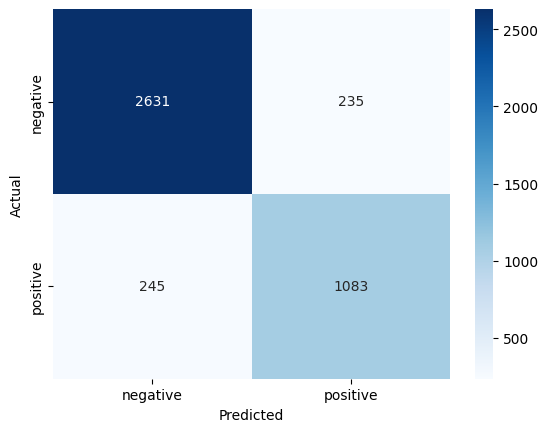

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(y_batch.numpy())

    print(classification_report(labels, preds, target_names=encoder.classes_))
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(lstm_model, test_loader)